Competition: https://www.kaggle.com/competitions/spaceship-titanic

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Read Data

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
sample_submission_df = pd.read_csv('./data/sample_submission.csv')

### Describe Data

In [3]:
train_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Histograms

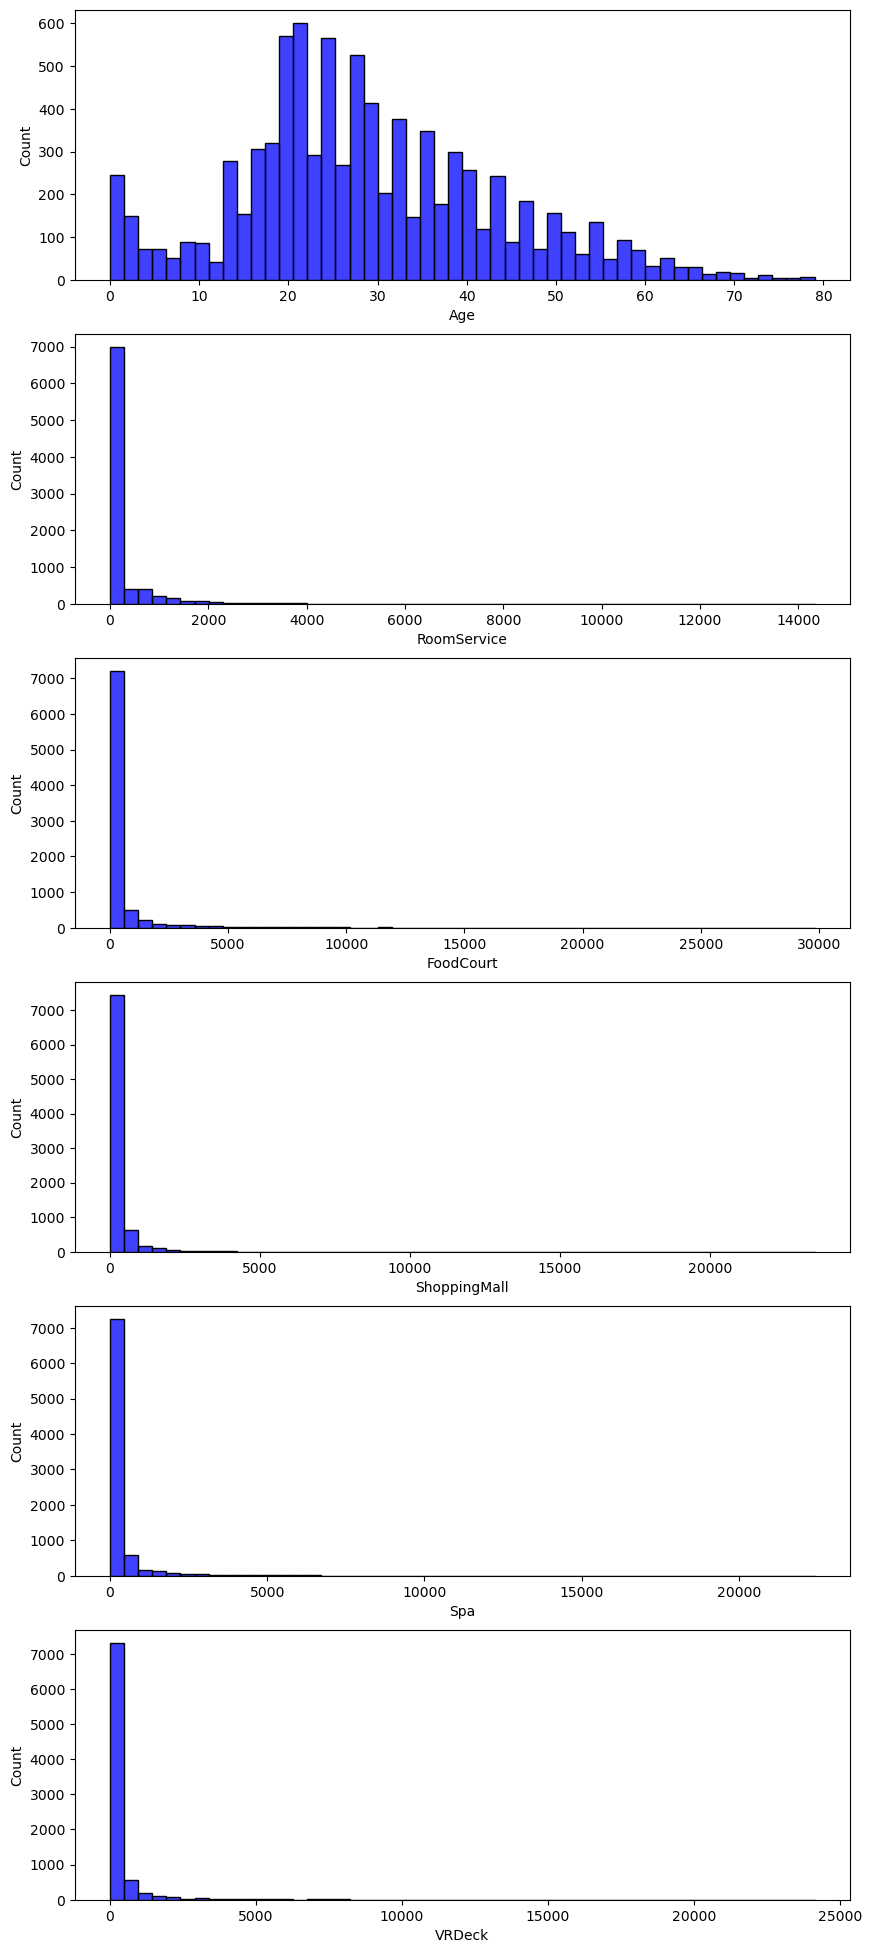

In [5]:
fig, ax = plt.subplots(6, 1, figsize=(10, 10))
plt.subplots_adjust(top=2)

for i, c in enumerate(train_df.drop(['PassengerId', 'Name'], axis=1).select_dtypes(include='number')):
    sns.histplot(train_df[c], color='b', bins=50, ax=ax[i])

### 'PassengerGroup' Creation

- There are too many groups here with too few counts of passengers in each for this to be of any predictive use

In [6]:
train_df['PassengerGroup'] = train_df['PassengerId'].str.split('_').str[0]
train_df['PassengerGroup'].value_counts()
train_df = train_df.drop(['PassengerGroup'], axis=1)

### 'HomePlanet' to 'Destination' Mapping

- Looks like most route mappings had similar chances for passengers to be transported
- Transportation across routes is averaged at about 50%
- Earh to TRAPPIST-1e had the lowest transportation at 39%
- Europa to PSO J318.5-22 had the highest transportation at 74%

In [7]:
grouped_df = train_df.groupby(['HomePlanet', 'Destination']).agg(
    Travelers=('Transported', 'size'),
    GotTransported=('Transported', 'sum')
).reset_index()

grouped_df['GotTransported'] = grouped_df['GotTransported'] / grouped_df['Travelers']
grouped_df

,HomePlanet,Destination,Travelers,GotTransported
0,Earth,55 Cancri e,690,0.504348
1,Earth,PSO J318.5-22,712,0.498596
2,Earth,TRAPPIST-1e,3101,0.389229
3,Europa,55 Cancri e,886,0.689616
4,Europa,PSO J318.5-22,19,0.736842
5,Europa,TRAPPIST-1e,1189,0.634987
6,Mars,55 Cancri e,193,0.611399
7,Mars,PSO J318.5-22,49,0.448980
8,Mars,TRAPPIST-1e,1475,0.511864


### Split 'Cabin' Into Pieces

In [8]:
train_df[["Cabin_Deck", "Cabin_Num", "Cabin_Side"]] = train_df["Cabin"].str.split("/", expand=True)
train_df['Cabin_Num'] = pd.to_numeric(train_df['Cabin_Num'], errors='coerce')
train_df[["Cabin_Deck", "Cabin_Num", "Cabin_Side"]]

,Cabin_Deck,Cabin_Num,Cabin_Side
0,B,0.0,P
1,F,0.0,S
2,A,0.0,S
3,A,0.0,S
4,F,1.0,S
...,...,...,...
8688,A,98.0,P
8689,G,1499.0,S
8690,G,1500.0,S
8691,E,608.0,S


### Impute for Nulls

- Future idea: impute for nulls by looking at records with similar values

In [9]:
print(train_df.shape)
print(train_df.isnull().sum().sort_values(ascending=False))

(8693, 17)
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin_Side      199
Cabin           199
Cabin_Num       199
Cabin_Deck      199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
PassengerId       0
dtype: int64


In [10]:
imputer = SimpleImputer(strategy='mean')

# numerical
for c in train_df.drop(['Cabin_Num', 'PassengerId', 'Name'], axis=1).select_dtypes(include='number'):
    train_df[c] = imputer.fit_transform(train_df[[c]])

# cabin number (we don't want decimals)
train_df['Cabin_Num'] = train_df['Cabin_Num'].fillna(train_df['Cabin_Num'].median())

# boolean
train_df[['VIP', 'CryoSleep']] = train_df[['VIP', 'CryoSleep']].fillna(value=0)

In [11]:
train_df = train_df.dropna(subset=['Destination', 'HomePlanet'], how='all')

In [12]:
print(train_df.shape)
print(train_df.isnull().sum().sort_values(ascending=False))

(8689, 17)
Name            200
Cabin_Side      199
Cabin           199
Cabin_Deck      199
HomePlanet      197
Destination     178
Spa               0
Cabin_Num         0
Transported       0
VRDeck            0
PassengerId       0
ShoppingMall      0
RoomService       0
VIP               0
Age               0
CryoSleep         0
FoodCourt         0
dtype: int64


### Final Dataset to Use

In [13]:
# --- drop unnecessary columns --- #
for col in ['PassengerId', 'Name', 'PassengerGroup', 'Cabin']:
    try: train_df = train_df.drop(col, axis=1)
    except KeyError as e: print(e)

train_df.head(5)

"['PassengerGroup'] not found in axis"


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Num,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1.0,S


In [14]:
# --- encode categorical data --- #
categorical = [
    'HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Side'
]
train_df = pd.get_dummies(train_df, columns=categorical)

# --- scale numerical data --- #
numerical = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
scaler = StandardScaler()
train_df[numerical] = scaler.fit_transform(train_df[numerical])

train_df.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Num,...,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,Cabin_Side_P,Cabin_Side_S
0,False,0.709601,False,-0.340615,-0.287338,-0.290847,-0.276731,-0.268939,False,0.0,...,False,True,False,False,False,False,False,False,True,False
1,False,-0.336621,False,-0.175423,-0.281694,-0.249007,0.211334,-0.230119,True,0.0,...,False,False,False,False,False,True,False,False,False,True
2,False,2.034816,True,-0.275447,1.955109,-0.290847,5.692951,-0.225708,False,0.0,...,True,False,False,False,False,False,False,False,False,True
3,False,0.291112,False,-0.340615,0.517209,0.330061,2.682774,-0.098661,False,0.0,...,True,False,False,False,False,False,False,False,False,True
4,False,-0.894607,False,0.118588,-0.243442,-0.038133,0.225558,-0.267175,True,1.0,...,False,False,False,False,False,True,False,False,False,True


### Train/Validation Split

In [15]:
X = train_df.drop('Transported', axis=1)
y = train_df['Transported']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

### Logistic Regression

In [16]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [17]:
val_preds = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))

Validation Accuracy: 0.7993862677406981
              precision    recall  f1-score   support

       False       0.81      0.78      0.79      1278
        True       0.79      0.82      0.81      1329

    accuracy                           0.80      2607
   macro avg       0.80      0.80      0.80      2607
weighted avg       0.80      0.80      0.80      2607



### Predictions with Test Data

In [18]:
test_df[["Cabin_Deck", "Cabin_Num", "Cabin_Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df['Cabin_Num'] = pd.to_numeric(test_df['Cabin_Num'], errors='coerce')
test_df[["Cabin_Deck", "Cabin_Num", "Cabin_Side"]]

,Cabin_Deck,Cabin_Num,Cabin_Side
0,G,3.0,S
1,F,4.0,S
2,C,0.0,S
3,C,1.0,S
4,F,5.0,S
...,...,...,...
4272,G,1496.0,S
4273,NaN,NaN,NaN
4274,D,296.0,P
4275,D,297.0,P


In [19]:
imputer = SimpleImputer(strategy='mean')

# numerical
for c in test_df.drop(['Cabin_Num', 'PassengerId', 'Name'], axis=1).select_dtypes(include='number'):
    test_df[c] = imputer.fit_transform(test_df[[c]])

# cabin number (we don't want decimals)
test_df['Cabin_Num'] = test_df['Cabin_Num'].fillna(train_df['Cabin_Num'].median())

# boolean
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

In [20]:
# test_df = test_df.dropna(subset=['Destination', 'HomePlanet'], how='all')

In [21]:
print(test_df.isnull().sum().sort_values(ascending=False))

Cabin           100
Cabin_Deck      100
Cabin_Side      100
Name             94
Destination      92
HomePlanet       87
PassengerId       0
CryoSleep         0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Cabin_Num         0
dtype: int64


In [22]:
passenger_ids = test_df['PassengerId']

In [23]:
# --- drop unnecessary columns --- #
for col in ['PassengerId', 'Name', 'PassengerGroup', 'Cabin']:
    try: test_df = test_df.drop([col], axis=1)
    except KeyError as e: print(e)

"['PassengerGroup'] not found in axis"


In [24]:
# --- encode categorical data --- #
categorical = [
    'HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Side'
]
test_df = pd.get_dummies(test_df, columns=categorical)

# --- scale numerical data --- #
numerical = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
scaler = StandardScaler()
test_df[numerical] = scaler.fit_transform(test_df[numerical])

test_df.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Num,HomePlanet_Earth,...,Cabin_Deck_A,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,Cabin_Side_P,Cabin_Side_S
0,True,-0.118222,False,-0.364780,-0.291352,-0.319859,-0.274558,-0.251561,3.0,True,...,False,False,False,False,False,False,True,False,False,True
1,False,-0.688601,False,-0.364780,-0.285385,-0.319859,2.283008,-0.251561,4.0,True,...,False,False,False,False,False,True,False,False,False,True
2,True,0.166968,False,-0.364780,-0.291352,-0.319859,-0.274558,-0.251561,0.0,False,...,False,False,True,False,False,False,False,False,False,True
3,False,0.666051,False,-0.364780,4.118523,-0.319859,-0.110576,0.222074,1.0,False,...,False,False,True,False,False,False,False,False,False,True
4,False,-0.617304,False,-0.348143,-0.291352,0.825745,-0.274558,-0.251561,5.0,True,...,False,False,False,False,False,True,False,False,False,True


In [25]:
y_preds = model.predict(test_df)

print(len(passenger_ids), len(y_preds))

output_df = pd.DataFrame(
    {'PassengerId': passenger_ids, 'Transported': y_preds}
)
output_df.to_csv('./results.csv', index=False)
output_df

4277 4277


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


### TODO

- Penalties of increasing $max\_iter$, and how to find optimal $max\_iter$
- Standarization vs. normalization
- Should use normalization?
- The different "solvers" for scikit-learn's $LogisticRegression$ model
- How to test for multicolinearity
- Set up data pipeline to feed $test\_df$ into to prepare for testing